## Transfer Learning for image Classification in pytorch

In [3]:
#kernels learn features,by layer by layer it learn deep features"

### Downloading Dataset

In [5]:
from torchvision.datasets.utils import download_url

In [6]:
download_url("https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz","./data")

In [7]:
import tarfile
with tarfile.open("./data/oxford-iiit-pet.tgz","r:gz") as tar:
    tar.extractall(path="./data")

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_26392\1739606697.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="./data")


In [8]:
from torch.utils.data import Dataset

In [9]:
import os
files=os.listdir("./data/oxford-iiit-pet/images")

In [10]:
def parse_breed(fname):
    parts=fname.split("_")
    return ''.join(parts[:-1])

In [11]:
parse_breed(files[7])

'Abyssinian'

In [12]:
from PIL import Image
def open_image(path):
    with open(path,"rb") as f:
        img=Image.open(f)
        return img.convert("RGB")

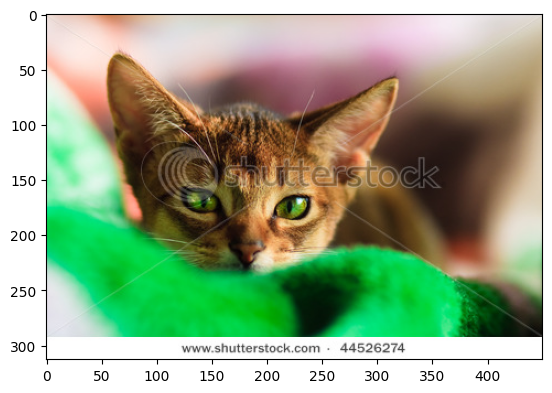

In [13]:
import matplotlib.pyplot as plt
plt.imshow(open_image("./data/oxford-iiit-pet/images/"+files[4]))

In [14]:
import os
class PetsDataset(Dataset):
    def __init__(self,root,transform):
        super().__init__()
        self.root=root
        self.files=[fname for fname in os.listdir(root) if fname.endswith(".jpg")]
        self.classes=list(set(parse_breed(fname) for fname in files))
        self.transform=transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        fname=self.files[i]
        fpath=os.path.join(self.root,fname)
        img=self.transform(open_image(fpath))
        class_idx=self.classes.index(parse_breed(fname))
        return img,class_idx

In [15]:
import torchvision.transforms as T
image_size=224
imagenet_stats=([0.485,0.456,0.406],[0.229,0.224,0.225])
dataset=PetsDataset("./data/oxford-iiit-pet/images",T.Compose([
    T.Resize(image_size),
    T.Pad(8,padding_mode="reflect"),
    T.RandomCrop(image_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
]))

In [16]:
import torch
from torch.utils.data import DataLoader,random_split

print(len(dataset))

7390


In [17]:
def denormalize(images,means,stds):
    images=images.unsqueeze(0)
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means
def show_images(images,label):
    images=denormalize(images,*imagenet_stats)[0].permute(1,2,0)
    plt.imshow(images)
    

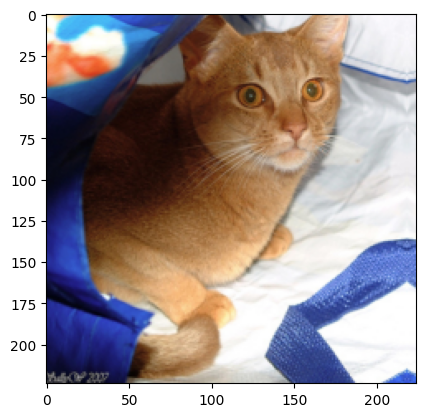

In [18]:
show_images(*dataset[2])

## Creating Training and Validation Sets

In [20]:
val_pct=0.1
val_size=int(val_pct*len(dataset))
train_ds,val_ds=random_split(dataset,[len(dataset)-val_size,val_size])


In [21]:
print(len(train_ds))
print(len(val_ds))

6651
739


In [22]:
train_dl=DataLoader(train_ds,num_workers=3,shuffle=True,batch_size=256,pin_memory=True)
val_dl=DataLoader(val_ds,num_workers=3,batch_size=256*2,pin_memory=True)


In [23]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images,labels in dl:
        plt.imshow(make_grid(denormalize(images[:64],*imagenet_stats).permute(1,2,0),nrow=8))
        break

In [ ]:
show_batch(train_dl)

## Modifying Pretrained model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"],result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
from torchvision import models
class PetsModel(ImageClassificationBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        self.network=models.resnet34(pretrained=pretrained)
        self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)
    def forward(self,xb):
        return self.network(xb)
        

In [ ]:
models.resnet34() #pretrained=True downloads weights 

## Setting up GPU

## Finetuning Pretrained Model

## Training a model from Scratch